# DELE ST1504 CA2
# PART A: GAN

<hr>

**NAME**: Irman Zafyree, Adam Tan, Joachim

**ADMIN NO**: `2300546`, `2300575`, `<ADM NO>`

**CLASS**: DAAA/FT/2B/07

<hr>

**Objective:**

Code a GAN model that is able to generate 260 small black-and-white images of the given dataset in 26 distinct classes.

# Initial Set Up

In [16]:
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

load_dotenv()

dataset_path = os.environ.get("DATASET_PATH")

print(dataset_path)




emnist-letters-train.csv


In [17]:
df = pd.read_csv(dataset_path, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
labels = df[0]

In [19]:
data = df.drop(df.columns[0], axis=1)
data.head()

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


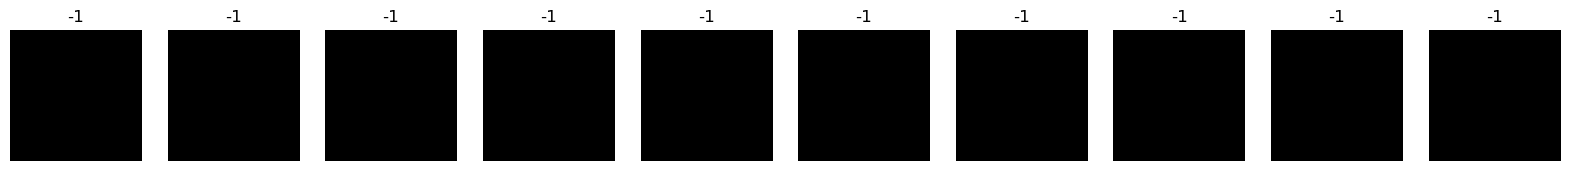

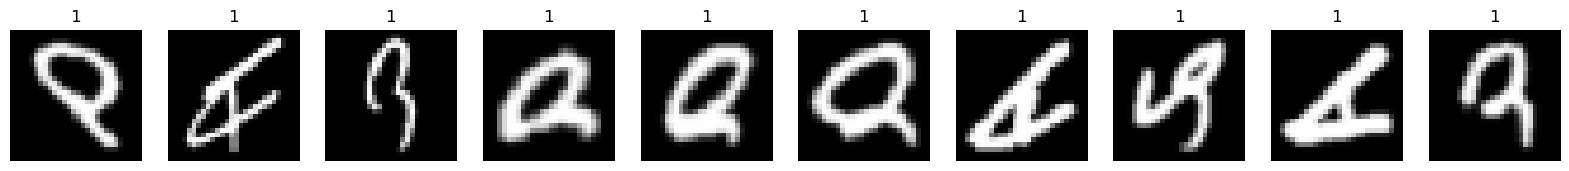

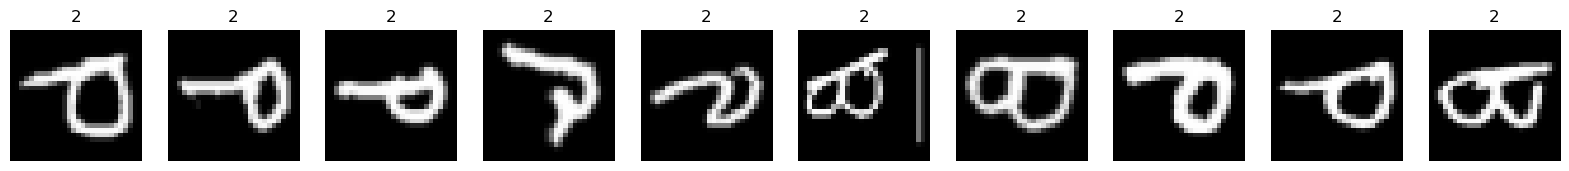

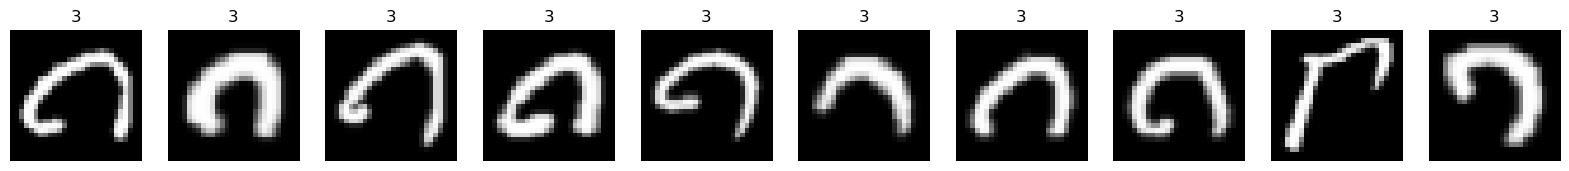

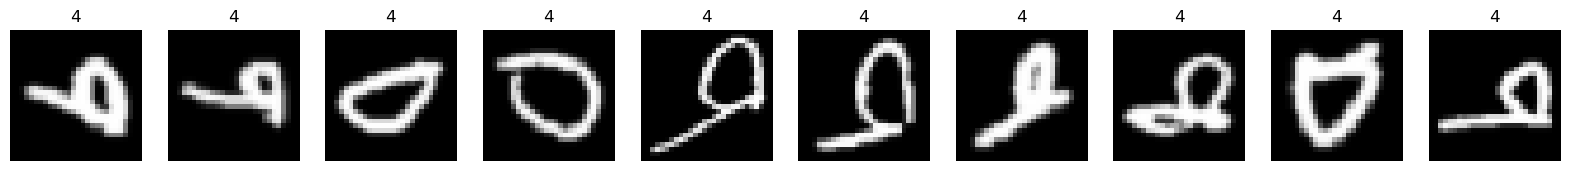

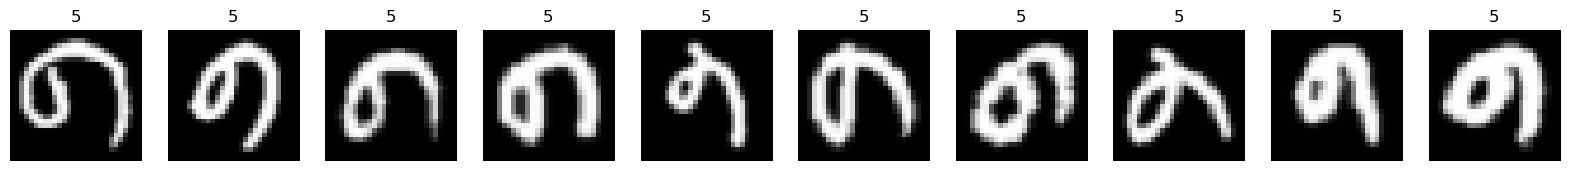

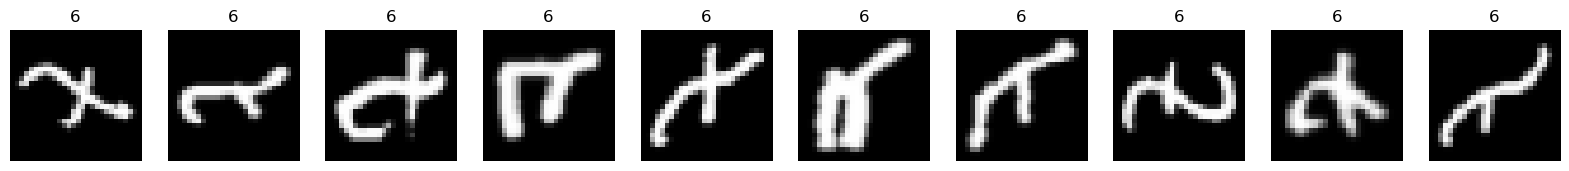

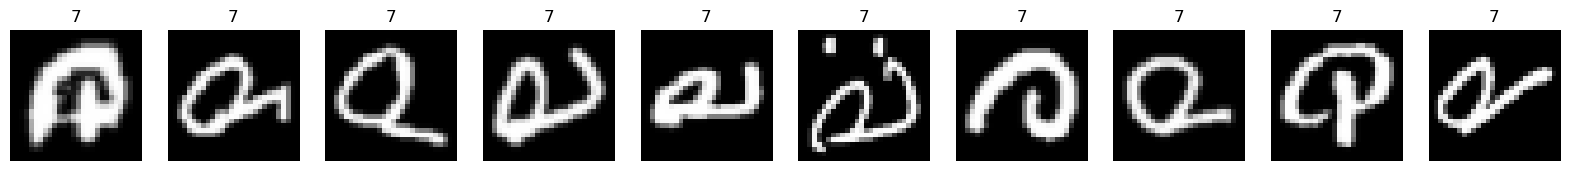

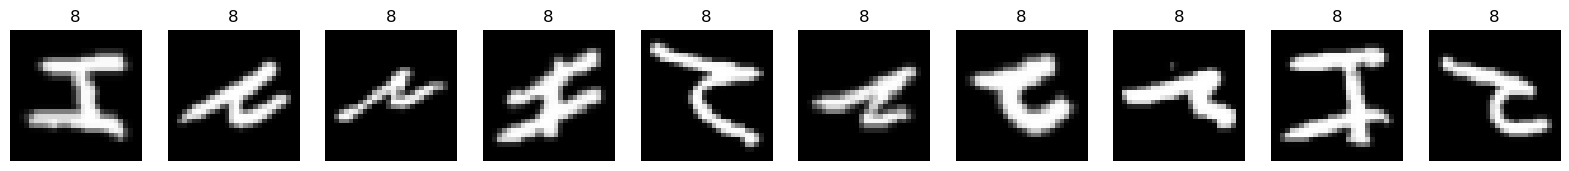

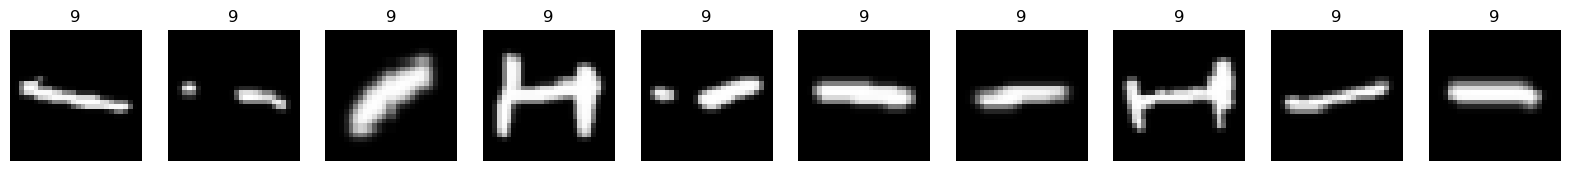

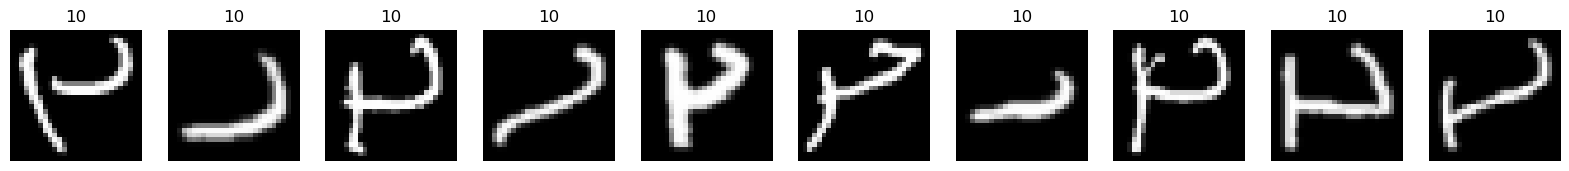

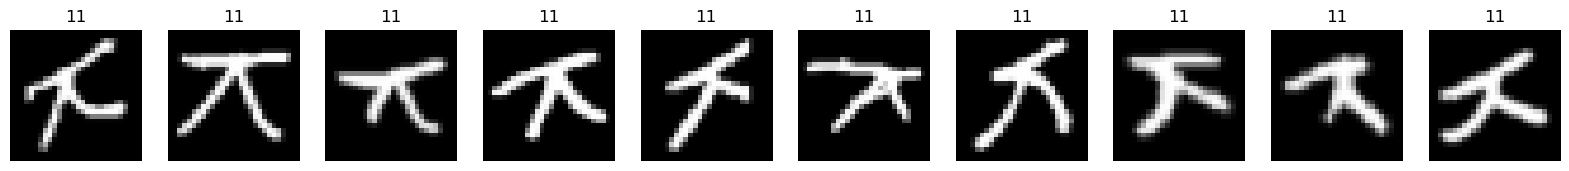

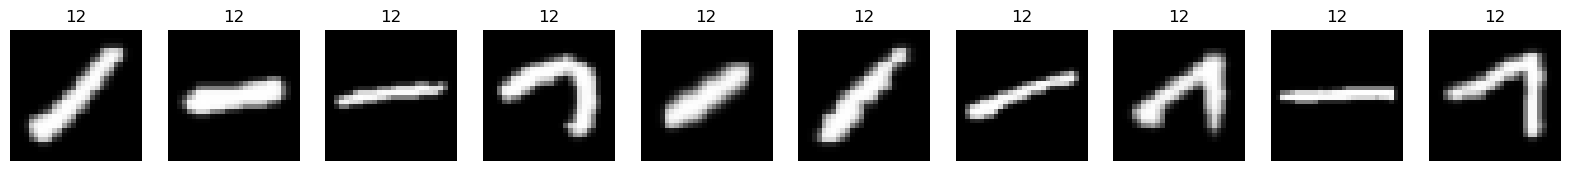

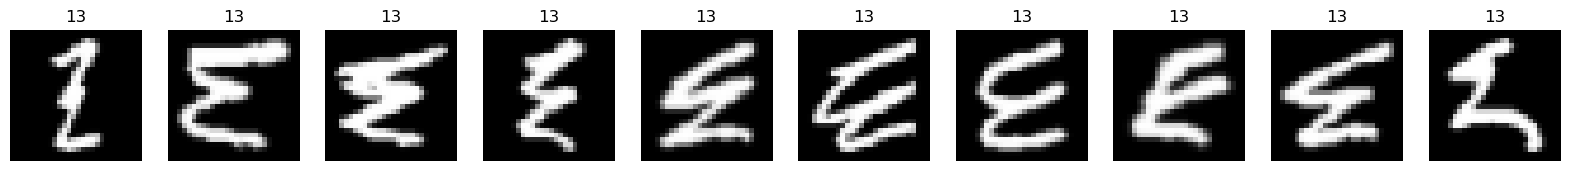

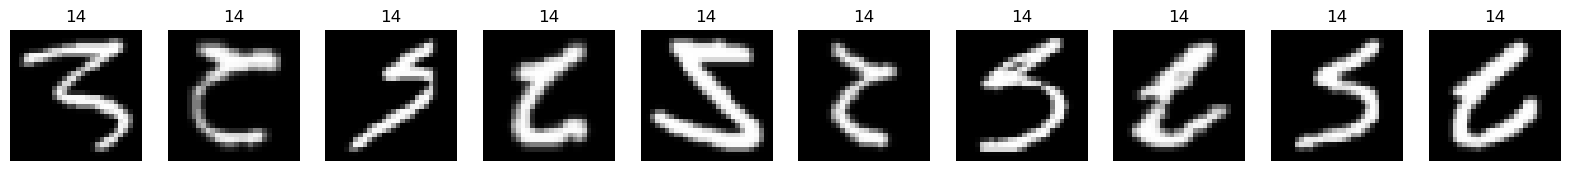

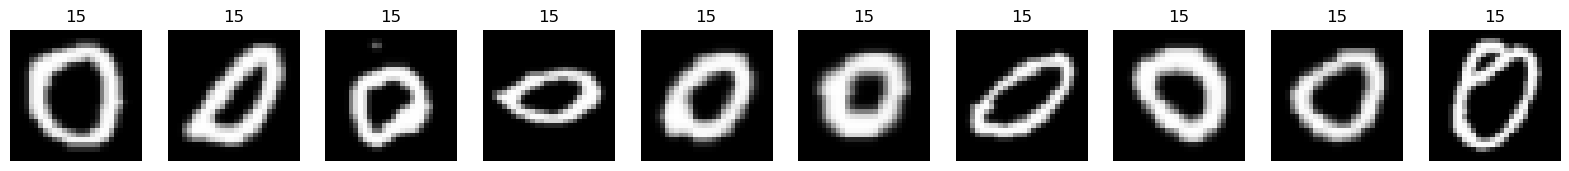

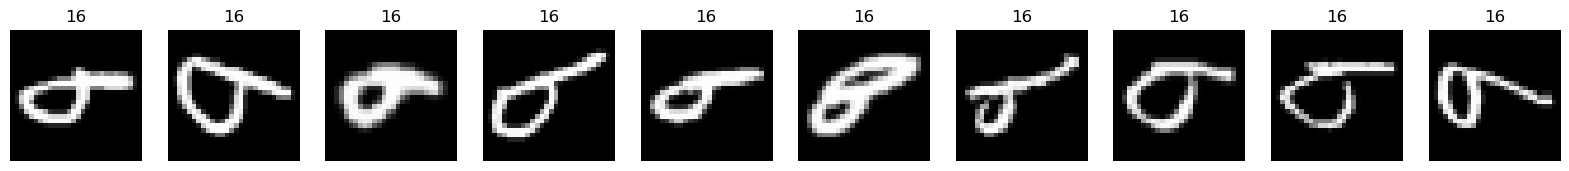

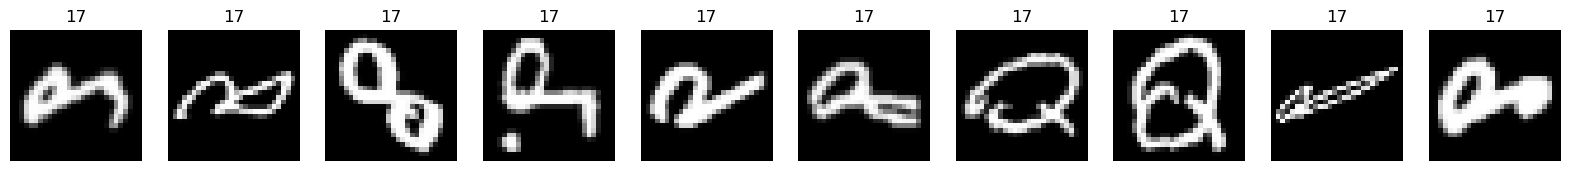

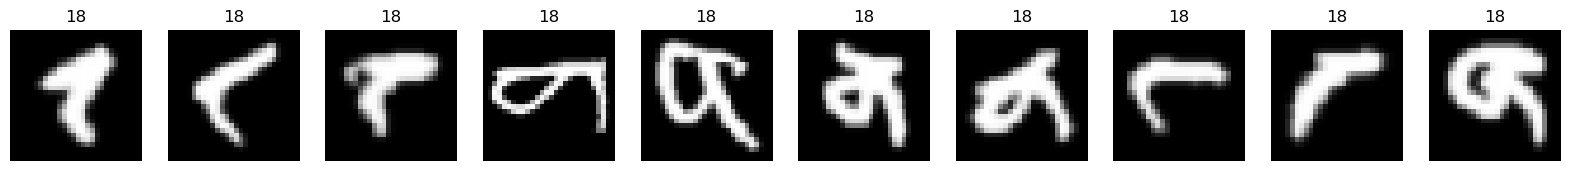

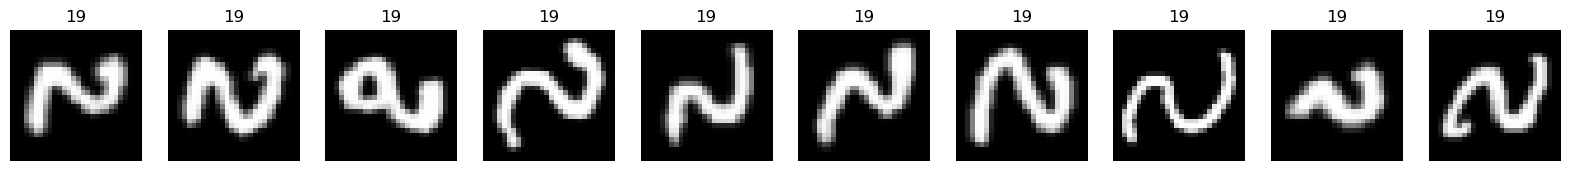

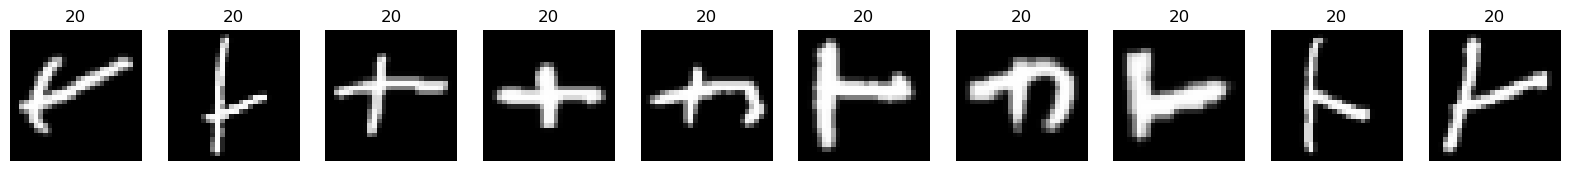

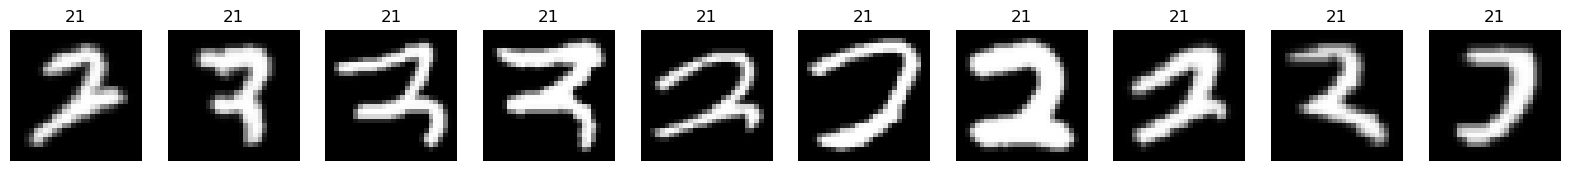

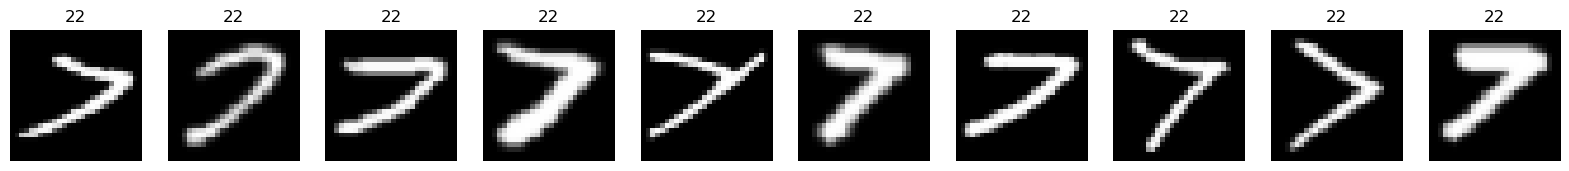

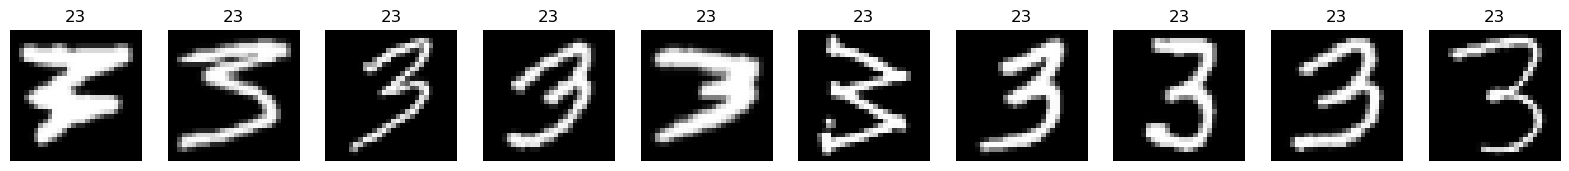

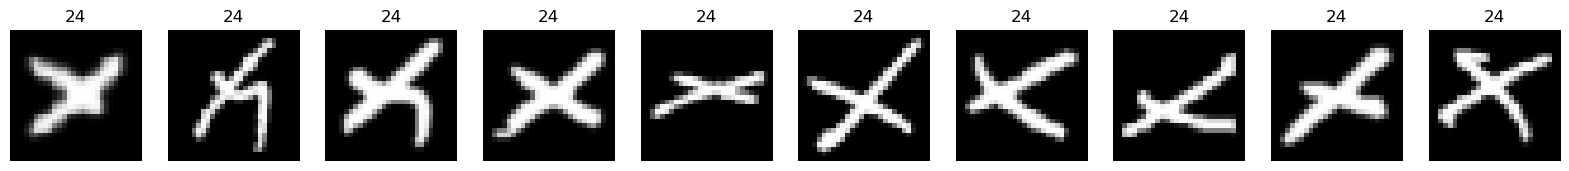

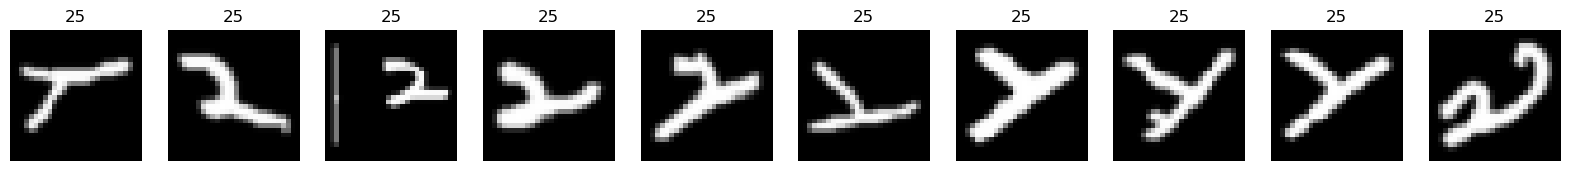

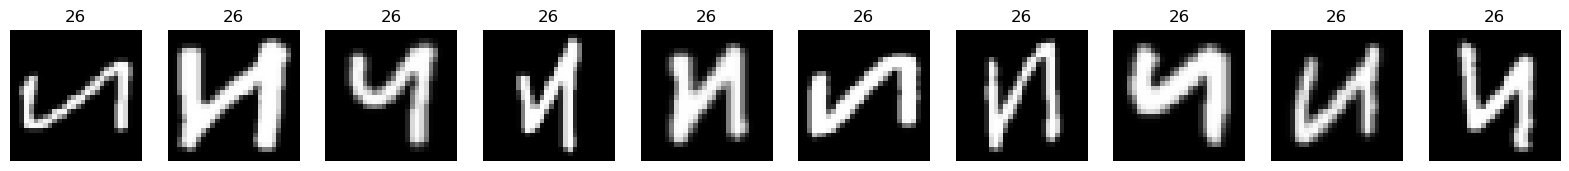

In [20]:

# Function to display images
def display_images(images, label):
    plt.figure(figsize=(20, 4))
    for index, image in enumerate(images[:10]):
        plt.subplot(1, 10, index + 1)
        plt.imshow(image.reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.title(f"{label}")

# Order labels from -1 to 26
ordered_labels = sorted(labels.unique(), key=lambda x: (x != -1, x))

# Iterate through each ordered label and display 10 images
for label in ordered_labels:
    label_images = data[labels == label].values
    display_images(label_images, label)
    plt.show()